In [211]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy.integrate import simps
import matplotlib
from IPython.display import display, Math, Latex, HTML
from matplotlib.patches import Rectangle
from scipy.fftpack import fft
%matplotlib inline  
matplotlib.rcParams['figure.figsize'] = [10., 5.]
matplotlib.rcParams["font.size"] = "16"
matplotlib.rcParams["lines.linewidth"] = "3"
matplotlib.rcParams["axes.grid"] = True

In [242]:
# Moments of Inertia
sensor_disc = {'m': 0.007, 'r': 0.025}
sensor_disc['i'] = 1/2 * sensor_disc['m'] * np.power(sensor_disc['r'], 2)
print(sensor_disc)
ring = {'m': 0.47, 'r_i': 0.054, 'r_o': 0.076}
ring['i'] = 1/2 * ring['m']*(np.power(ring['r_i'], 2) + np.power(ring['r_o'], 2))
print(ring)
ring_plate = {'m': 0.1194, 'r': 0.047}
ring_plate['i'] = 1/2 * ring_plate['m'] * np.power(ring_plate['r'], 2)
print(ring_plate)
rod = {'m': 0.0281, 'r': 0.19}
rod['i'] = 1/12 * rod['m'] * np.power(rod['r'], 2) + 2*0.755*np.power(rod['r'], 2)
print(rod)

{'m': 0.007, 'r': 0.025, 'i': 2.1875000000000007e-06}
{'m': 0.47, 'r_i': 0.054, 'r_o': 0.076, 'i': 0.0020426199999999998}
{'m': 0.1194, 'r': 0.047, 'i': 0.00013187730000000002}
{'m': 0.0281, 'r': 0.19, 'i': 0.054595534166666668}


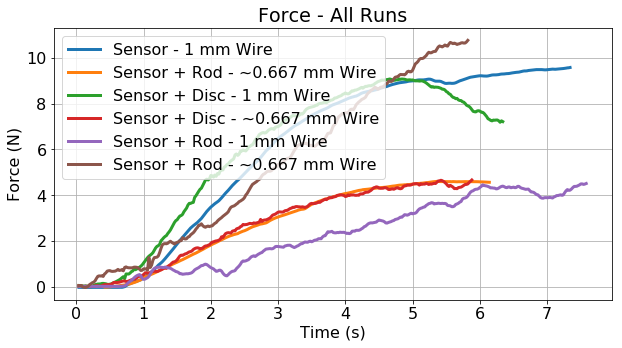

In [260]:
def load_frame(fname, plot=False):
    df = pd.read_csv(fname)[2:].copy()
    
    for col in ['Time (s)', 'Force (N)', 'Angle (rad)']:
        for idx, v in enumerate(df[col]):
            if np.isnan(v):
                df = df[:idx-1].copy()

    del df['T (N · m)']
    del df['Velocity (m/s)']
    del df['Acceleration (m/s²)']
    del df['Position (m)']
    
    df['T (N · m)'] = df['Force (N)'] * sensor_disc['r']
    
    if plot:
        plt.plot(df['Time (s)'], df['Force (N)'])

    return df

    
# Load Data Frames
df_k = load_frame('k.csv', plot=True)
df_kN = load_frame('k N.csv', plot=True)
    
df_kD = load_frame('k Disc.csv', plot=True)
df_kDN = load_frame('k Disc N.csv', plot=True)

df_kRN = load_frame('k Rod N.csv', plot=True)
df_kR = load_frame('k Rod.csv', plot=True)

plt.legend(['Sensor - 1 mm Wire', 'Sensor + Rod - ~0.667 mm Wire', 'Sensor + Disc - 1 mm Wire',
           'Sensor + Disc - ~0.667 mm Wire','Sensor + Rod - 1 mm Wire', 'Sensor + Rod - ~0.667 mm Wire'])
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.title('Force - All Runs')
plt.show()

df_T = load_frame('T.csv')
df_TN = load_frame('T N.csv')

df_TD = load_frame('T Disc.csv')
df_TDN = load_frame('T Disc N.csv')

df_TR = load_frame('T Rod.csv')
df_TRN = load_frame('T Rod N.csv')

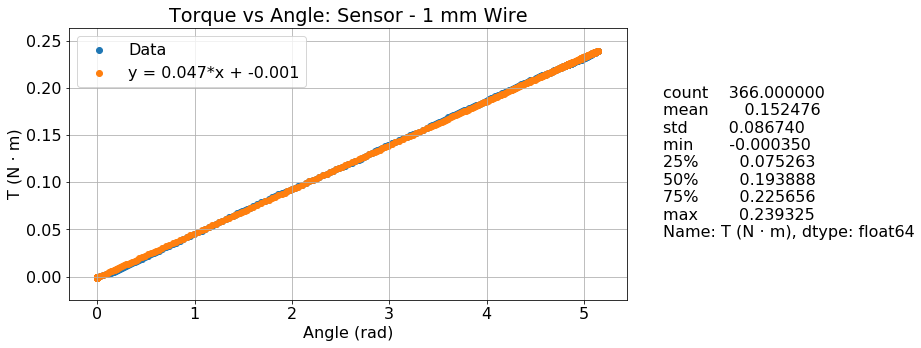

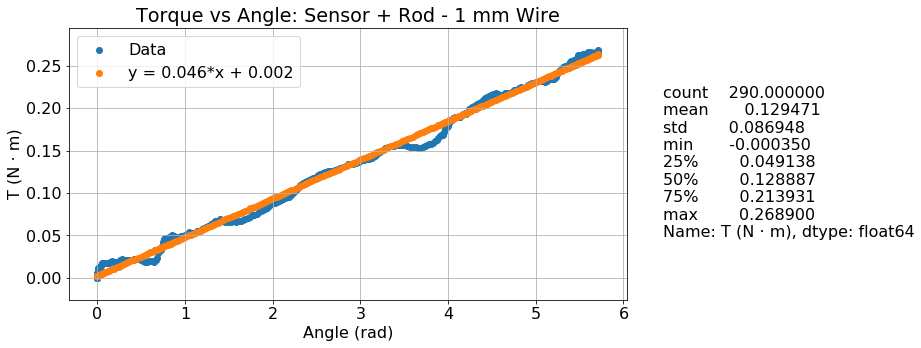

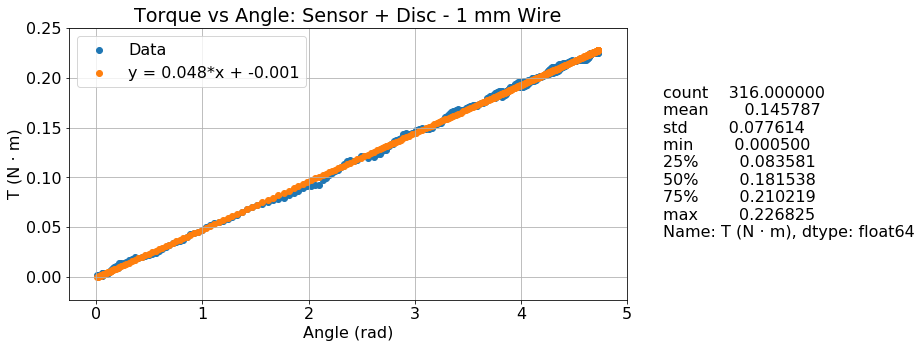

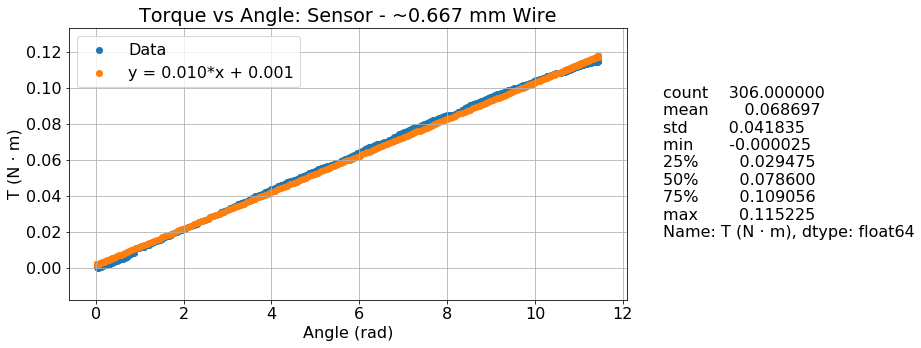

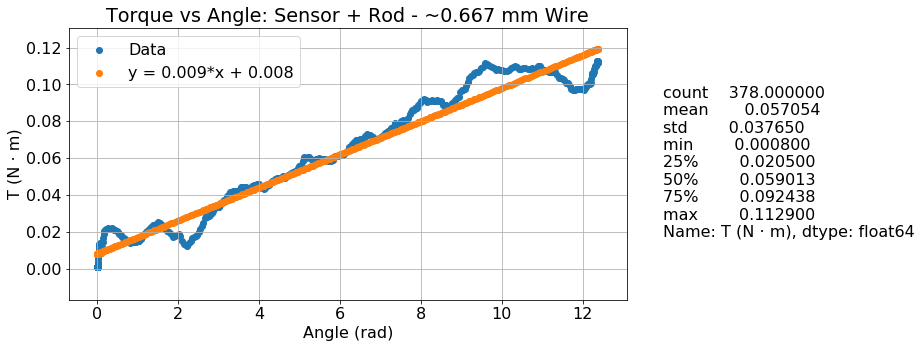

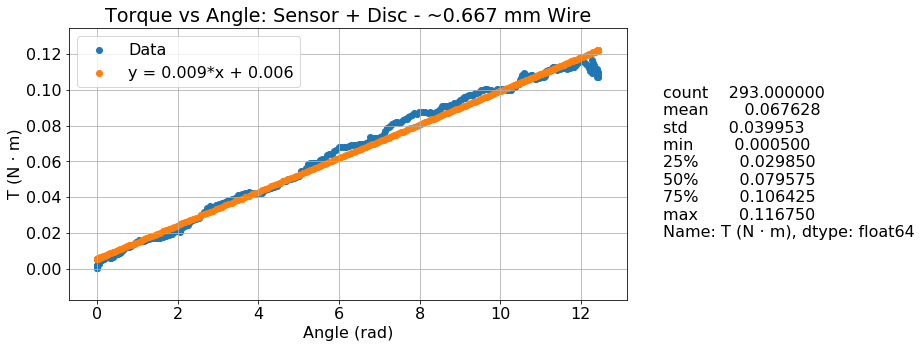

In [244]:
def fit_linear_eq(x_vals, y_vals):
    reg = linear_model.LinearRegression()
    reg.fit(x_vals.values.reshape(x_vals.shape[0], 1), y_vals.values.reshape(y_vals.shape[0], 1))

    m = reg.coef_[0]
    b = reg.intercept_

    return m, b

def linear_eq(x, m, b):
    return m*x + b

def lab_k(df, title):
    results = {}
    m, b = fit_linear_eq(df['Angle (rad)'] , df['T (N · m)'])
        
    linear_vals = np.zeros((df['T (N · m)'].shape[0]))
    for x_idx, x in enumerate(df['Angle (rad)']):
        linear_vals[x_idx] = linear_eq(x, m, b)
        
    plt.scatter(df['Angle (rad)'], df['T (N · m)'])
    plt.scatter(df['Angle (rad)'], linear_vals)

    plt.xlabel('Angle (rad)')
    plt.ylabel('T (N · m)')

    
    legend_data = "Data"
    legend_fit = "y = %.3f*x + %.3f" % (m, b)
    plt.legend([legend_data, legend_fit])
    t = 'Torque vs Angle: %s' % title
    plt.title(t)
        
    plt.figtext(0.95, 0.3, df['T (N · m)'].describe())

    plt.savefig(t + '.png', bbox_inches='tight')
    plt.show()
    
    return m

    
k_m = lab_k(df_k, 'Sensor - 1 mm Wire')
kR_m = lab_k(df_kR, 'Sensor + Rod - 1 mm Wire')
kD_m = lab_k(df_kD, 'Sensor + Disc - 1 mm Wire')

kN_m = lab_k(df_kN, 'Sensor - ~0.667 mm Wire')
kRN_m = lab_k(df_kRN, 'Sensor + Rod - ~0.667 mm Wire')
kDN_m = lab_k(df_kDN, 'Sensor + Disc - ~0.667 mm Wire')



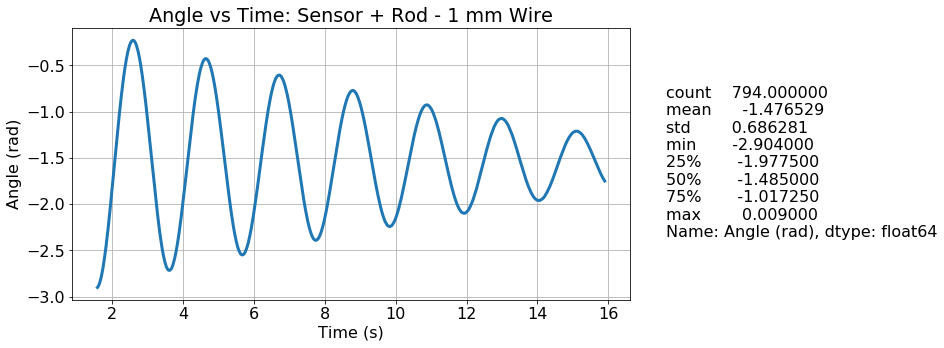

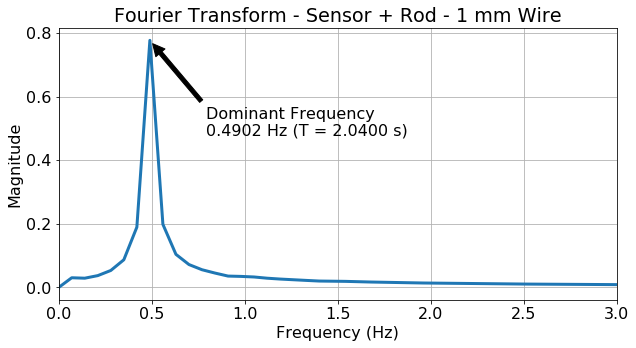

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

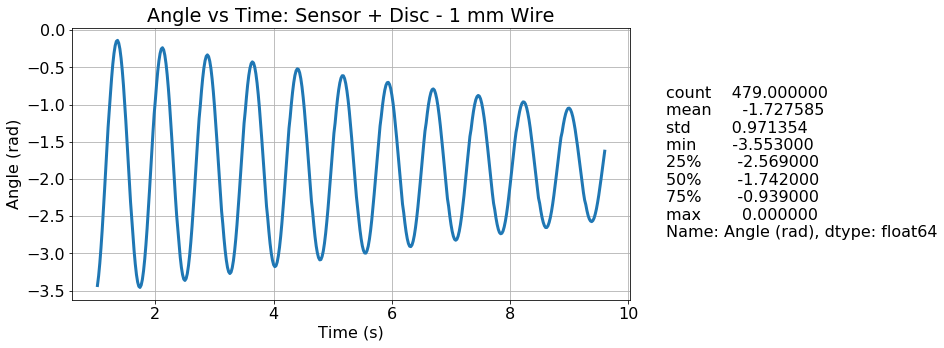

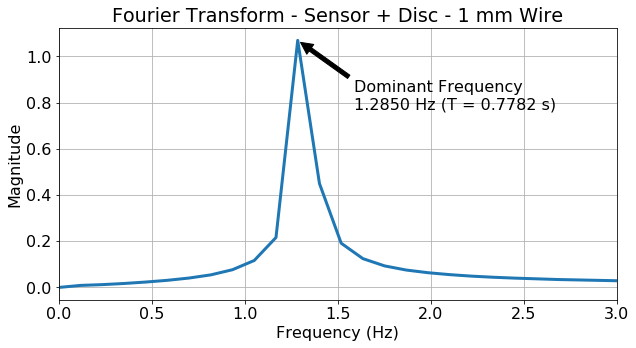

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

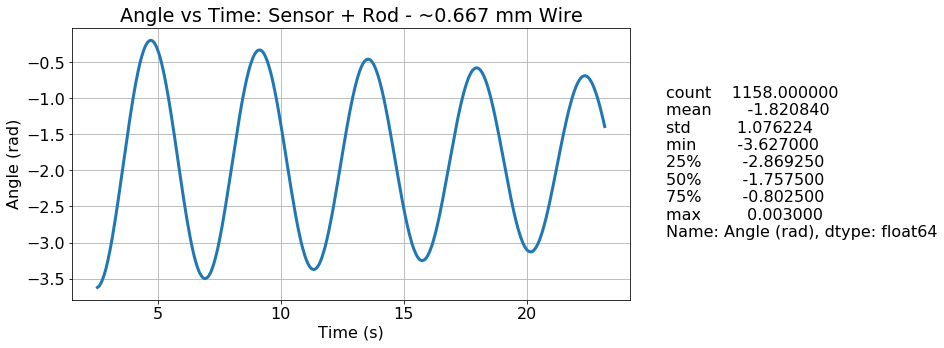

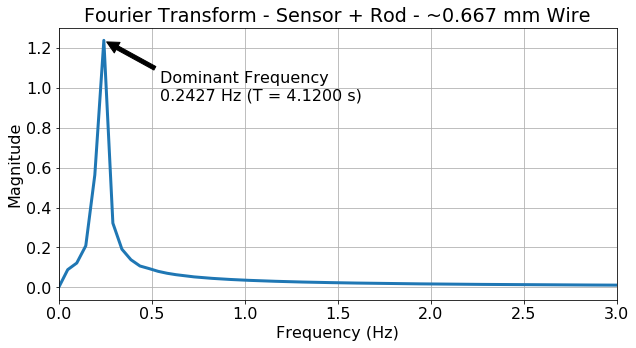

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

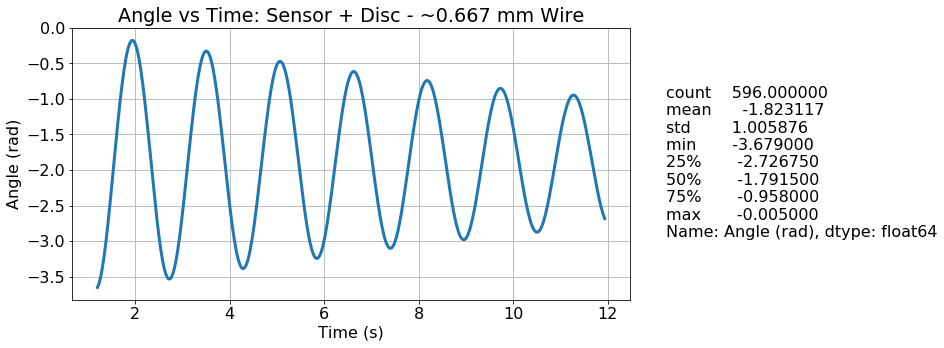

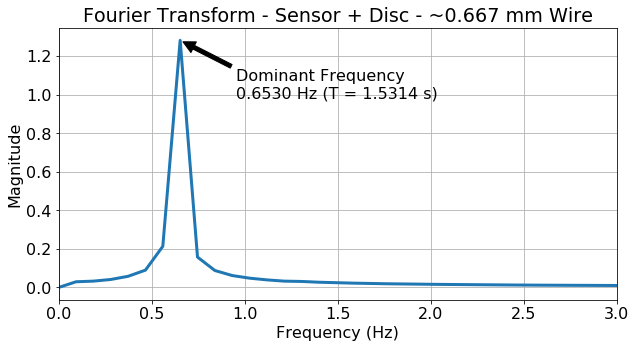

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{'Tc': array([ 3.02605048]),
 'Tm': 1.5314285714285711,
 'dT': array([ 49.39183664])}

In [246]:
def lab_t(df, title, I, k, do_fft=True):

    if do_fft:
        plt.plot(df['Time (s)'][df['Angle (rad)'].argmin():], df['Angle (rad)'][df['Angle (rad)'].argmin():])
        plt.ylabel('Angle (rad)')
        plt.xlabel('Time (s)')
        t = 'Angle vs Time: %s' % title
        plt.title(t)
        plt.figtext(0.95, 0.3, df['Angle (rad)'].describe())
        plt.savefig(t + '.png', bbox_inches='tight')
        plt.show(t)

        new_angle =  df['Angle (rad)'][df['Angle (rad)'].argmin():].copy()
        new_angle = new_angle.reset_index(drop = True)

        new_angle += abs(new_angle.mean())

        # Number of sample points
        N = len(new_angle)
        # sample spacing
        T = df['Time (s)'][3] - df['Time (s)'][2]
        x = np.linspace(0.0, N*T, N)
        y = new_angle
        yf = fft(y)
        xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

        y_final = 2.0/N * np.abs(yf[0:N//2])

        fig = plt.figure()
        ax = fig.add_subplot(111)

        hz = xf[y_final.argmax()]
        T = 1 / xf[y_final.argmax()]
        ax.annotate('Dominant Frequency\n%.4f Hz (T = %.4f s)' % (hz, T), 
                    xy=(xf[y_final.argmax()], y_final.max()), 
                    xytext=(xf[y_final.argmax()]+0.3, y_final.max()-0.3),
                    arrowprops=dict(facecolor='black', shrink=0.05),
                    )

        plt.plot(xf, y_final)
        plt.xlim(0, 3)
        plt.ylabel('Magnitude')
        plt.xlabel('Frequency (Hz)')
    
        t = 'Fourier Transform - %s' % title
        plt.title(t)
        plt.savefig(t + '.png')

        plt.show()
        
        T_calculated = 2*np.pi*np.sqrt(I/k)
        display(Math(r'%f=2*pi*\sqrt{\frac{%f}{%f}}' % (T_calculated, I,k)))
        print('')
        
        display(Math(r'T=2*pi*\sqrt{\frac{I}{k}}'))
        print('')
        
        T_diff = abs( (T-T_calculated) / T_calculated) * 100
        
        display(Math(r'\%diff = \lvert\frac{T_m-T_c}{T_c}\rvert*100'))
        print('')
        display(Math(r'%f = \lvert\frac{%f-%f}{%f}\rvert*100' % (T_diff, T, T_calculated, T_calculated)))

        return {'Tm': T, 'Tc': T_calculated, 'dT': T_diff}

    
        
lab_t(df_T, 'Sensor - 1 mm Wire', 
      sensor_disc['i'], 
      k_m, 
      do_fft=False)
lab_t(df_TR, 'Sensor + Rod - 1 mm Wire', 
      sensor_disc['i'] + rod['i'], 
      kR_m)
lab_t(df_TD, 'Sensor + Disc - 1 mm Wire', 
      sensor_disc['i'] + ring['i'] + ring_plate['i'], 
      kD_m)

lab_t(df_TN, 'Sensor - ~0.667 mm Wire', 
      sensor_disc['i'], 
      kN_m,
     do_fft=False)
lab_t(df_TRN, 'Sensor + Rod - ~0.667 mm Wire', 
      sensor_disc['i'] + rod['i'], 
      kRN_m)
lab_t(df_TDN, 'Sensor + Disc - ~0.667 mm Wire', 
      sensor_disc['i'] + ring['i'] + ring_plate['i'], 
      kDN_m)

